<a href="https://colab.research.google.com/github/joyinning/causal_inference/blob/main/Causal_Week_8_1_(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resource: https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

# Chapter 21

## Concepts

**Question 1 Meta learners, which are used to estimate Conditional Average Treatment Effect (CATE) in causal inference, are highly dependent on specific factors. On what are these meta learners primarily dependent?**

Meta learners are highly dependent on the machine learning methods they utilize as components. These can range from linear regression and boosted decision trees to neural networks and Gaussian processes. The effectiveness of a meta learner is significantly influenced by the choice of these underlying predictive models. Therefore, it is often necessary to experiment with various approaches to determine which works best in a given context.

### S-Learner
The simplest learner that uses a single machine learning model M to estimate **mu(x) = E[Y|T, X]** (the expected value of the outcome variable Y, given the treatment T and covariates X).
- CATE: M(X, T=1) - M(X, T=0)

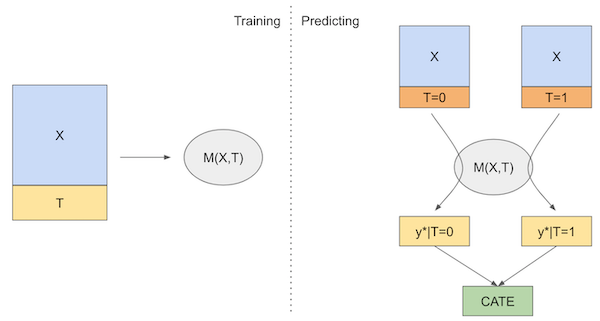

**Question 2 What is the purpose of evaluating a model using the cumulative gain curve?**


The purpose is to visualize the effectiveness of the model in ranking cases according to their likelihood of being positive and to help in understanding how much better a model is in identifying positive cases compared to a random guess. (How well the model can prioritize individuals who are most affected by the treatment, which is crucial for targeting interventions effeciently.)

**Question 3 Why does the S-learner tend to bias the treatment effect towards zero, and how does regulaization impact this bias?**

- The S-learner tends to bias the treatment effect towards zero because it models the treatment effect within the same framework as the other covariates, often using regularized regression or similar approaches.
- Regularization generally shrinks the coefficients towards zero to prevent overfitting, which can disproportionately affect the treatment variable if it is not a strong predictor in the presence of other covariates. (It leads to underestimation of the true effect of the treatment.)

**Question 4 What are the major disadvantages of using an S-learner for estimating treatment effects?**


1. **Bias Towards Zero**: The S-learner has a tendency to bias the estimation of treatment effects towards zero, especially when the treatment effect is small or similar in magnitude to the noise within the data. This occurs because the regularization techniques often used in S-learners can diminish the estimated coefficients of variables that are weak predictors in the presence of other stronger predictors.
2. **Equal Treatment of Variables**: The S-learner treats the treatment variable similarly to other covariates, which may lead to underestimation or complete disregard of the treatment effect if the treatment is not a strong influence in the presence of other variables. This can be problematic in models where the treatment effect is subtle but clinically or economically significant.
3. **Limitations in Complex Scenarios**: While the simplicity of the S-learner is beneficial for straightforward applications, it can be a limitation in more complex scenarios. Specifically, the S-learner may not adequately capture treatment effects that vary significantly across different subgroups or where interactions between covariates are crucial to understanding the treatment effect.

### T-Learner

The learner that uses one model per treatment variable.
- In the binary case, there are only two models needed to be estimated.
- CATE: M1(X) - M0(X)

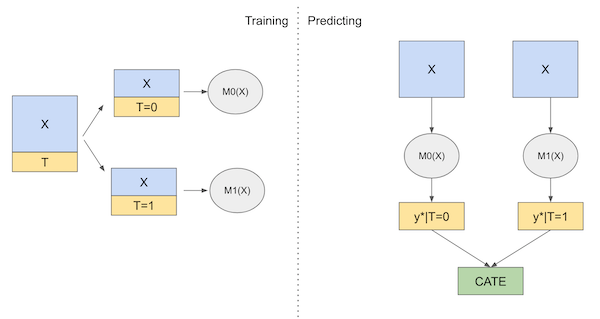

**Question 5 Why might the T-learner show a higher training performance compared to its testing performance on a dataset?**

The T-learner showing a higher performance in training than in testing typically indicates overfitting, because it fits seperate models for the treated and untreated groups.
- When each model is trained on only a subset of the data, the reduced number of data points can lead the models to learn noise rather than the underlying pattern, especially if the treated group has significantly fewer instances than the untreated group.

**Question 6 What challenges arise when using the T-learner for estimating CATE when there is a small number of treated observations?**

- When using the T-learner with a small number of treated observations, the model for the treated grouptends to be overly simplistic to prevent overfitting, often leading to a biased estimate of CATE if there's nonlinearity in the outcome variable.
- In contrast, the model for the untreated group can afford more complexity due to a larger dataset, potentially picking up non-linear patterns, resulting in an incorrect nonlinear CATE estimate when the true CATE is constant.

### X-Learner

The learner has two stages and a propensity score model.
1. identical to the T-learner
2. impute the treatment effect for the control and for the treated using the models above

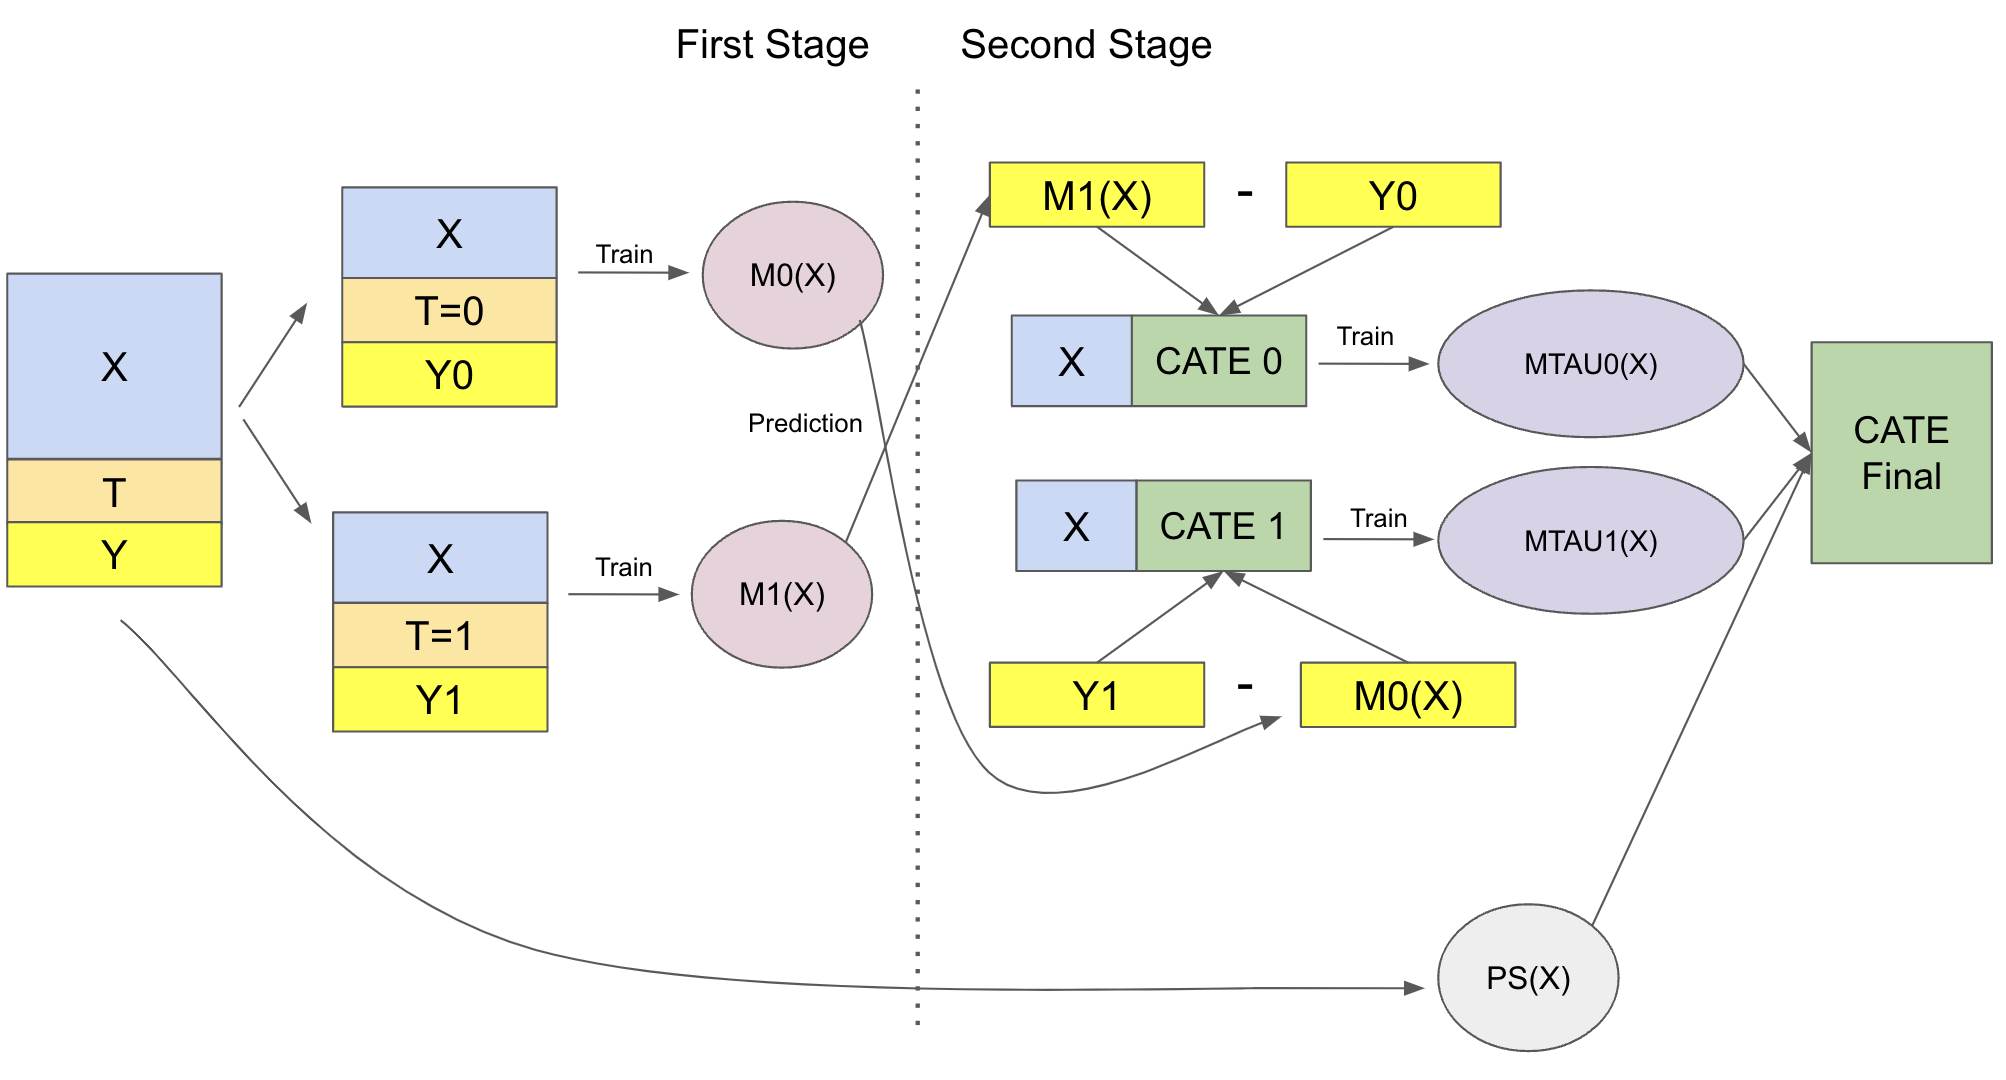

**Question 7 How does the X-learner correct for the biased treatment effect estimations when dealing with imbalanced treatment groups, and why is this important?**

1. It follows the T-learner model by fitting separate models for treated and untreated groups. Then, in the second stage, it imputes treatment effects for each group using these models. This learner uses a propensity score model to weight the imputed treatment effects from each group, giving more weight to the model trained with more data.
2. It is important when dealing with imbalanced treatment groups because it compensates for the smaller sample size in one of the groups, which can lead to overfitting or underfitting.

**Question 8 Compare the performance of the X-learner with the S and T learners in handling datasets with significant differences in the size of treatment groups. What advantages does the X-learner provide in such scenarios?**

- The X-learner is specifically designed to address the challenges posed by imbalanced data.
> The T-learner can suffer from overfitting in the smaller treatment gruop, and the S-learner might overly simplify the treatment effect across all subjects, the X-learner effectively uses the dta from both groups to estimate a more accurate CATE.

## Case Study

**Dataset**

In [1]:
import pandas as pd
import numpy as np

np.random.seed(432)
n_patients = 10000
ages = np.random.normal(50, 20, n_patients)
weights_kg = np.random.uniform(30, 100, n_patients)
weights_lb = weights_kg * 2.20462
comorbid = np.random.binomial(1, 0.2, n_patients)

# Binary Treatment Scenario
treatment = np.random.binomial(1, 0.5, n_patients)

# Calculating effect
effect = 2.0 * treatment - 0.05 * ages + 0.015 * weights_lb - 0.7 * comorbid * treatment + np.random.normal(0, 0.1, size=n_patients)
outcome = np.random.binomial(1, p=1 / (1 + np.exp(-effect)), size=n_patients)

data = pd.DataFrame({
    'age': ages,
    'weight': weights_lb,
    'comorbid': comorbid,
    'drug': treatment,
    'outcome': outcome
})

1. age: Age of the customer.
2. weight: Weight of the customer.
3. comorbid: Pre-existing medical conditions of the patient.
4. drug(treatment): The dosage of the drug administered to the patient, typically measured in milligrams or as a categorical variable indicating low, medium, or high dosage.
5. outcome: The response of the patient to the treatment, which could be measured as an improvement score, change in symptoms, or a binary variable indicating success (1) or failure (0) of the treament.

In [2]:
data.head()

,age,weight,comorbid,drug,outcome
0,53.737545,154.959351,0,0,0
1,50.689946,106.231509,0,1,1
2,42.304912,94.763875,0,1,1
3,59.291804,213.731704,0,1,0
4,62.017850,219.876681,0,0,1


In [22]:
data.describe()

,age,weight,comorbid,drug,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.203067,143.166321,0.205300,0.504400,0.600000
std,19.842367,44.323363,0.403941,0.500006,0.489922
min,-19.668646,66.141347,0.000000,0.000000,0.000000
25%,36.424241,104.783742,0.000000,0.000000,0.000000
50%,50.120496,143.330288,0.000000,1.000000,1.000000
75%,63.621078,181.691474,0.000000,1.000000,1.000000
max,123.190841,220.420009,1.000000,1.000000,1.000000


### Using a drug treatment dataset, how can we identify which patient types exhibit a more positive response to the drug (higher CATE) and which may experience a negative response (CATE < 0), employing S-learner, T-learner, and X-learner methods? (Interpret results of each learner)

**1. S-Learner**

In [3]:
y = "outcome"
T = "drug"
X = ["age", "weight", "comorbid"]

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.3, random_state = 42)

Use LGBMRegressor

In [17]:
from lightgbm import LGBMRegressor
np.random.seed(123)
s_learner = LGBMRegressor(max_depth = 20, min_child_samples = 30)
s_learner.fit(train[X+[T]], train[y]);

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 4
[LightGBM] [Info] Start training from score 0.606571


In [19]:
train['cate'] = s_learner.predict(train[X].assign(**{T: 1})) - s_learner.predict(train[X].assign(**{T: 0}))
test['cate'] = s_learner.predict(test[X].assign(**{T: 1})) - s_learner.predict(test[X].assign(**{T: 0}))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Plot and interpret the results.

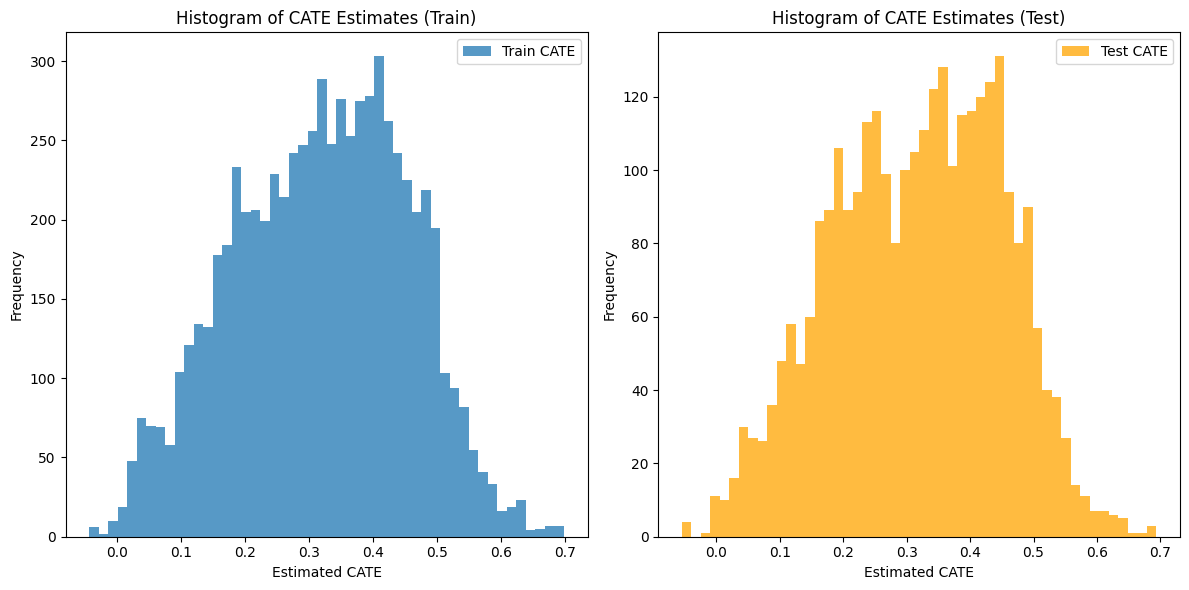

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train['cate'], bins=50, alpha=0.75, label='Train CATE')
plt.xlabel('Estimated CATE')
plt.ylabel('Frequency')
plt.title('Histogram of CATE Estimates (Train)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test['cate'], bins=50, alpha=0.75, label='Test CATE', color='orange')
plt.xlabel('Estimated CATE')
plt.ylabel('Frequency')
plt.title('Histogram of CATE Estimates (Test)')
plt.legend()

plt.tight_layout()
plt.show()

1. The mean or median of the CATE distribution for each set (train, test) are positive. A positive central value suggests a generally beneficial effect of the treatment.
2. The two distributions don't show the wide spread, indicating that the treatment doesn't have varying effects on different subgroups, (more uniform effect)
3. There may be the presence of distinct subgroups within the population in the test group that respond differently to the treatment.

In [29]:
def plot_cumulative_gain(data, label):
    sorted_data = data.sort_values('cate', ascending=False)
    cum_outcomes = np.cumsum(sorted_data['outcome'])
    total_outcomes = cum_outcomes.iloc[-1]
    cumulative_gain = cum_outcomes / total_outcomes
    percentage_of_data = np.linspace(0, 1, len(cumulative_gain))
    return percentage_of_data, cumulative_gain

In [30]:
x_train, gain_train = plot_cumulative_gain(train, 'Train')
x_test, gain_test = plot_cumulative_gain(test, 'Test')

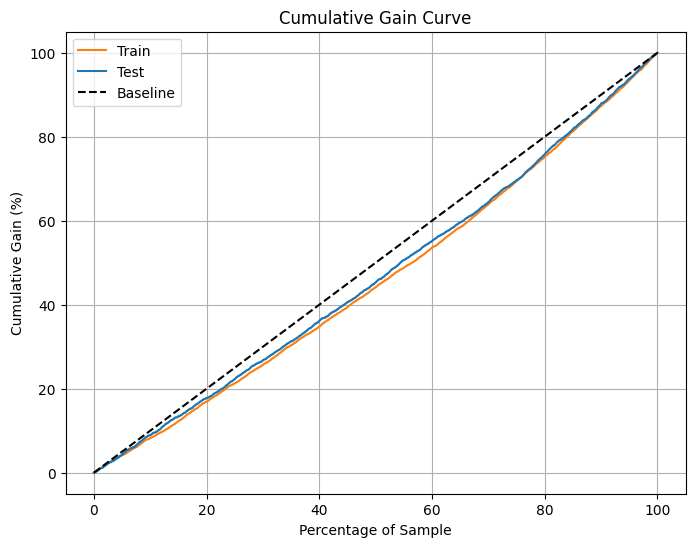

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(x_train * 100, gain_train * 100, label='Train', color='C1')
plt.plot(x_test * 100, gain_test * 100, label='Test', color='C0')

plt.plot([0, 100], [0, 100], 'k--', label='Baseline')

plt.xlabel('Percentage of Sample')
plt.ylabel('Cumulative Gain (%)')
plt.title('Cumulative Gain Curve')
plt.legend()
plt.grid(True)
plt.show()

1. The curves are close to the baseline: the model is not effectively distinguishing between individuals who are likely to benefit from the treatment and those who are not.
2. The similarity between the train and test curves: the model behaves similarly on both seen (train) and unseen (test) data, indicating that there is no overfitting.

**2. T-Learner**

In [ ]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
train['cate'] = m1.predict(train[X]) - m0.predict(train[X])
test['cate'] = m1.predict(test[X]) - m0.predict(test[X])

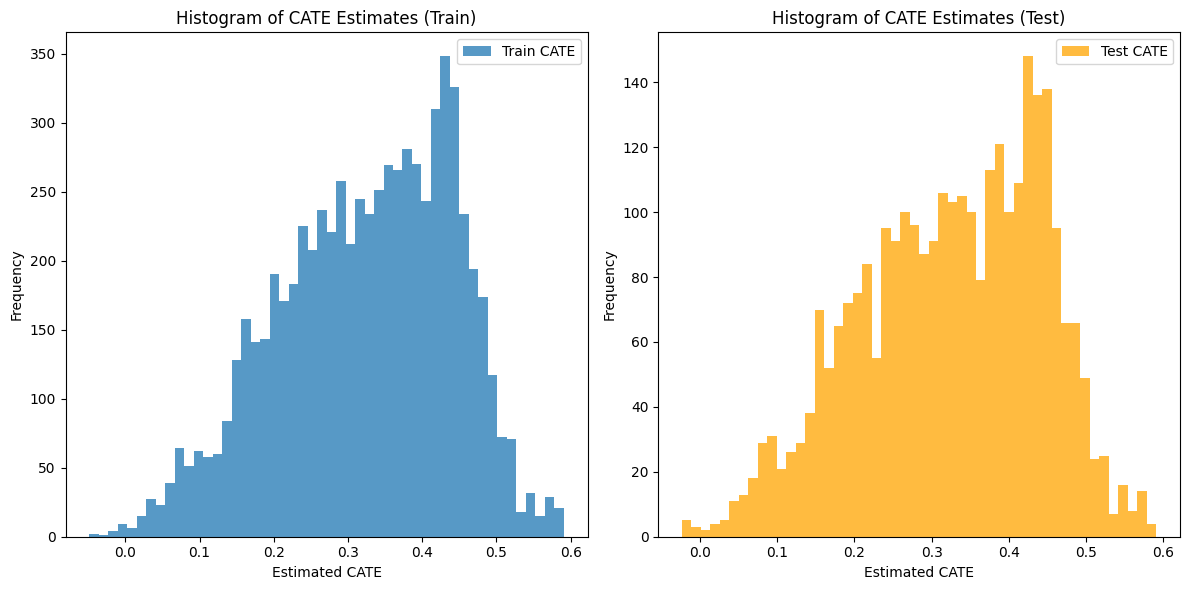

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train['cate'], bins=50, alpha=0.75, label='Train CATE')
plt.xlabel('Estimated CATE')
plt.ylabel('Frequency')
plt.title('Histogram of CATE Estimates (Train)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test['cate'], bins=50, alpha=0.75, label='Test CATE', color='orange')
plt.xlabel('Estimated CATE')
plt.ylabel('Frequency')
plt.title('Histogram of CATE Estimates (Test)')
plt.legend()

plt.tight_layout()
plt.show()

1. The mean or median of the CATE distribution for each set (train, test) are positive. A positive central value suggests a generally beneficial effect of the treatment.
2. The two distributions don't show the wide spread, indicating that the treatment doesn't have varying effects on different subgroups, (more uniform effect)
3. In the case of weak left skewness, the distribution is closer to normal but with a slight shift indicating that most individuals still benefit from the treatment, with fewer experiencing slightly less effective results. The outcomes are generally positive, with only a mild variation toward lesser effectiveness.

In [40]:
x_train, gain_train = plot_cumulative_gain(train, 'Train')
x_test, gain_test = plot_cumulative_gain(test, 'Test')

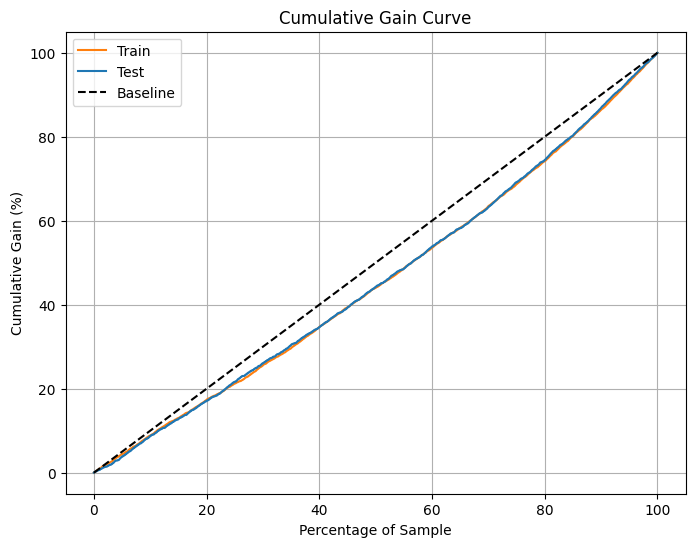

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(x_train * 100, gain_train * 100, label='Train', color='C1')
plt.plot(x_test * 100, gain_test * 100, label='Test', color='C0')

plt.plot([0, 100], [0, 100], 'k--', label='Baseline')

plt.xlabel('Percentage of Sample')
plt.ylabel('Cumulative Gain (%)')
plt.title('Cumulative Gain Curve')
plt.legend()
plt.grid(True)
plt.show()

1. The curves are close to the baseline: the model is not effectively distinguishing between individuals who are likely to benefit from the treatment and those who are not.
2. The similarity between the train and test curves: the model behaves similarly on both seen (train) and unseen (test) data, indicating that there is no overfitting.

**3. X-Learner**

The first stage, exactly the same as the T-Learner.

In [ ]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none')

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

g.fit(train[X], train[T]);

Impute the treatment effect and fit the second stage models on them.

In [ ]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

Make corrected predictions using the propensity score model.

In [44]:
def ps_predict(df, t):
    return g.predict_proba(df[X])[:, t]


x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

In [45]:
train['cate'] = x_cate_train
test['cate'] = x_cate_test['cate']

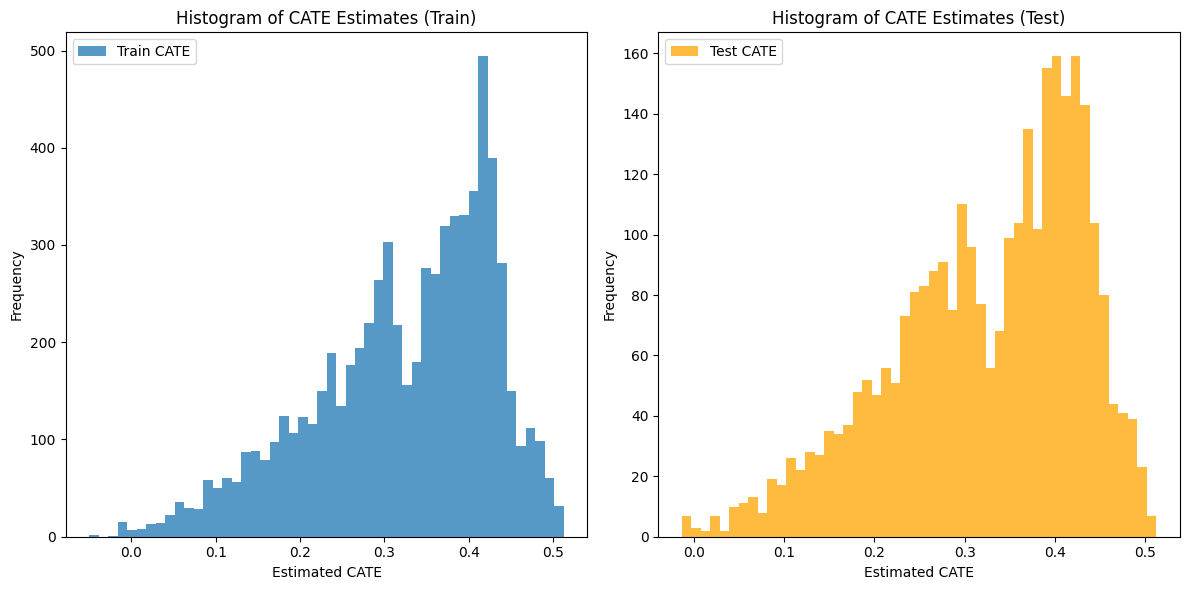

In [46]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train['cate'], bins=50, alpha=0.75, label='Train CATE')
plt.xlabel('Estimated CATE')
plt.ylabel('Frequency')
plt.title('Histogram of CATE Estimates (Train)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test['cate'], bins=50, alpha=0.75, label='Test CATE', color='orange')
plt.xlabel('Estimated CATE')
plt.ylabel('Frequency')
plt.title('Histogram of CATE Estimates (Test)')
plt.legend()

plt.tight_layout()
plt.show()


1. The mean or median of the CATE distribution for each set (train, test) are positive. A positive central value suggests a generally beneficial effect of the treatment.
2. The two distributions don't show the wide spread, indicating that the treatment doesn't have varying effects on different subgroups, (more uniform effect)
3. If the histogram shows strong left skewness, this would mean that the treatment is very effective for the majority of individuals, with a small number experiencing significantly poorer outcomes. The effect of the skew indicates that while most patients benefit greatly, the few who do not, experience notably worse results.

In [47]:
x_train, gain_train = plot_cumulative_gain(train, 'Train')
x_test, gain_test = plot_cumulative_gain(test, 'Test')

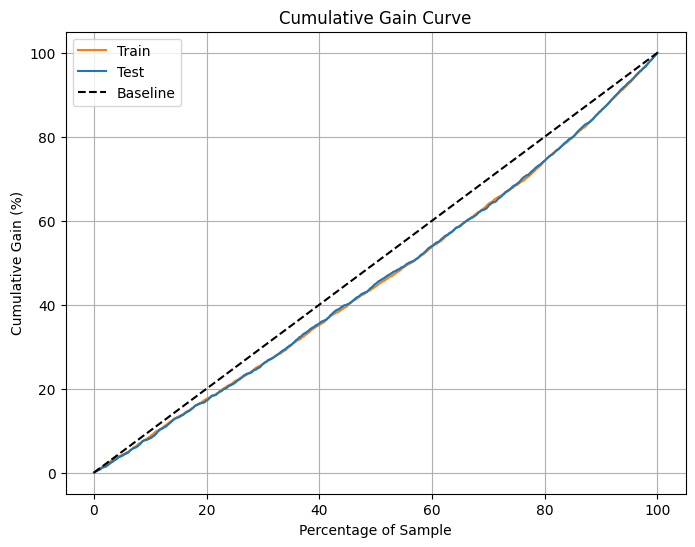

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(x_train * 100, gain_train * 100, label='Train', color='C1')
plt.plot(x_test * 100, gain_test * 100, label='Test', color='C0')

plt.plot([0, 100], [0, 100], 'k--', label='Baseline')

plt.xlabel('Percentage of Sample')
plt.ylabel('Cumulative Gain (%)')
plt.title('Cumulative Gain Curve')
plt.legend()
plt.grid(True)
plt.show()

1. The curves are close to the baseline: the model is not effectively distinguishing between individuals who are likely to benefit from the treatment and those who are not.
2. The similarity between the train and test curves: the model behaves similarly on both seen (train) and unseen (test) data, indicating that there is no overfitting.

### Conclusion

1. S-learner: The S-learner shows a uniform beneficial effect of the treatment across all patient types but struggles to differentiate between those who benefit more or less, as indicated by cumulative gain curves close to the baseline.
2. T-learner: Similarly, the T-learner indicates a generally positive treatment effect with consistent results across patient groups, but its predictive performance is limited, failing to identify distinct benefits among different subgroups.
3. **X-learner: The X-learner suggests a generally positive effect for most patients but identifies a left skew in the CATE distribution, indicating that while many benefit significantly, a few experience poorer outcomes, hinting at potential subgroups that respond differently to the treatment.**